## Install

In [ ]:
# %env AM_I_DOCKER=False
# %env BUILD_WITH_CUDA=True
# %env CUDA_HOME=/usr/local/cuda-11.8
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
# %cd /kaggle/working/GroundingDINO
# !pip install -e .
# !pip install git+https://github.com/facebookresearch/segment-anything.git
!wget 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
# !pip install git+https://github.com/huggingface/transformers
# !pip install diffusers invisible-watermark

## Imports

In [13]:
import argparse
import os
import copy

import numpy as np
import torch,torchvision
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from groundingdino.util.inference import Model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor , sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda')

In [ ]:
%cd /kaggle/working/GroundingDINO
GROUNDING_DINO_CONFIG_PATH = "./groundingdino/config/GroundingDINO_SwinT_OGC.py"
!wget "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
GROUNDING_DINO_CHECKPOINT_PATH = "./groundingdino_swint_ogc.pth"

In [7]:
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont

# Define the URL of the image
url = "https://cdn.shopclues.com/images/thumbnails/29504/320/320/1491451903230.jpg"

# Send a GET request to the URL
response = requests.get(url)

# Open the response content as an image
img = Image.open(BytesIO(response.content))
# response.content

In [ ]:
image=np.array(img)
image

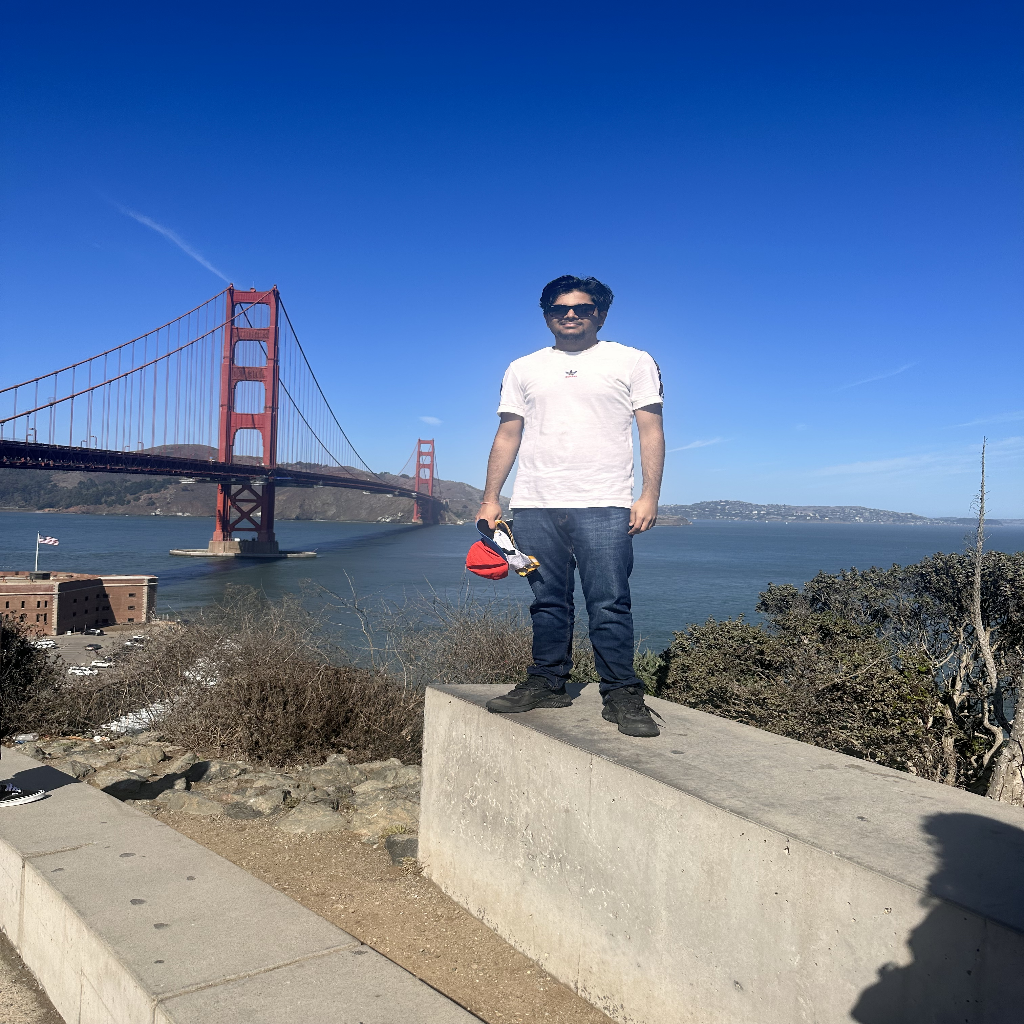

In [25]:
IMAGE_PATH = "/kaggle/input/pics-of-me/IMG_2180.jpeg"
image=cv2.imread(IMAGE_PATH)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,dsize=(1024,1024))
# detections
Image.fromarray(image)

In [ ]:
def create_mask(image_path, dino_config_file, dino_checkpoint,box_threshold)

In [26]:
TEXT_PROMPT= ["shirt"]
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

grounding_dino_model = Model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)

detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

final text_encoder_type: bert-base-uncased


In [ ]:
box_annotator = sv.BoxAnnotator()
labels = [
    f"{TEXT_PROMPT[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# save the annotated grounding dino image
# annotated_frame=cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
# cv2.imwrite("groundingdino_annotated_image.jpg", annotated_frame)
Image.fromarray(annotated_frame)

In [ ]:
#NMS Suppression
print(f"Before NMS: {len(detections.xyxy)} boxes")
nms_idx = torchvision.ops.nms(
    torch.from_numpy(detections.xyxy), 
    torch.from_numpy(detections.confidence), 
    NMS_THRESHOLD
).numpy().tolist()

detections.xyxy = detections.xyxy[nms_idx]
detections.confidence = detections.confidence[nms_idx]
detections.class_id = detections.class_id[nms_idx]

print(f"After NMS: {len(detections.xyxy)} boxes")


In [19]:
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=device)
predictor = SamPredictor(sam)

In [27]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

# detections.mask = segment(
#     sam_predictor=sam_predictor,
#     image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
#     xyxy=detections.xyxy
# )
# predictor.set_image(image)
# input_boxes=torch.tensor(detections.xyxy).to(device)
# transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
# masks, _, _ = predictor.predict_torch(
#     point_coords=None,
#     point_labels=None,
#     boxes=transformed_boxes,
#     multimask_output=False,
# )

masks=segment(predictor,image,detections.xyxy)

In [ ]:
def combine_masks(masks:np.array)->np.array:
    m0=masks[0].astype(np.uint8)*255
    m1=masks[1].astype(np.uint8)*255
    mask_comb=cv2.bitwise_or(m0,m1)
    
    return mask_comb

In [ ]:
image_mask=Image.fromarray(masks[0])
init_image=Image.fromarray(image)
image_mask

## Stable Diffusion for inpainting

In [ ]:
from diffusers import ControlNetModel, StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image, make_image_grid

# load ControlNet
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, variant="fp16").to(device)

# pass ControlNet to the pipeline
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16, variant="fp16"
).to(device)

# load base and mask image
# prepare control image
def make_inpaint_condition(init_image, mask_image):
    init_image = np.array(init_image.convert("RGB")).astype(np.float32) / 255.0
    mask_image = np.array(mask_image.convert("L")).astype(np.float32) / 255.0

    assert init_image.shape[0:1] == mask_image.shape[0:1], "image and image_mask must have the same image size"
    init_image[mask_image > 0.5] = -1.0  # set as masked pixel
    init_image = np.expand_dims(init_image, 0).transpose(0, 3, 1, 2)
    init_image = torch.from_numpy(init_image)
    return init_image

# control_image = make_inpaint_condition(init_image, mask_image)

In [ ]:
control_image = make_inpaint_condition(init_image, image_mask)
prompt = "the man is wearing blue jeans, suggest a great shirt to wear with it. 4k"
negative_prompt = "deformed, disfigured, poor details"
# #image and mask_image should be PIL images.
# #The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=init_image, mask_image=image_mask, control_image=control_image).images[0]

In [1]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
from PIL import Image

init_image=Image.open('/Users/rewatsachdeva/Desktop/DL/pic3.jpeg')
init_image=init_image.resize((768,768))
image_mask=Image.open('/Users/rewatsachdeva/Desktop/DL/mask.png')

pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16"
).to(device='mps')
    
#     generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 18 files:  83%|████████▎ | 15/18 [05:36<01:07, 22.46s/it]


In [ ]:
with torch.no_grad():
    prompt = "white jacket white stripes. 4k"
    generator = torch.Generator(device="mps").manual_seed(1)
    image = pipeline(prompt=prompt, image=init_image, mask_image=image_mask, generator=generator).images[0]

In [ ]:
image

In [ ]:
#For removing the background
image_inp=np.array(image_inpainting)
image_mask=masks[0].astype(np.uint8)*255
result = cv2.cvtColor(image_inp, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = image_mask
Image.fromarray(result)

In [40]:
result=cv2.resize(result,dsize=(512,512))
cv2.imwrite('blue shirt.png',result)

True